In [1]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools
from functions import *
from constants import *
from datetime import datetime
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 4)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=7)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


RESULTADOS PRIMEER CONSULTA:


,FECHA_EJECUCION,TEST,MODEL,FORECAST_TO_DO,MONTHS_TO_FORECAST,MONTHS_TO_TEST,FROM_YEAR,TOTAL_MODELOS,MAPE_DEACERO,P15,P50,P85,MIN_MAPE_DEACERO,MAX_MAPE_DEACERO,NUMERO_COMBINACIONES
0,2025-10-17 12:13:17,0,Todos los modelos,ToneladasFacturadas,6,6,2022,8,237.06093,14.9956,48.4076,90.3364,0.0,350401.8891,868


PARAMETROS DE EJECUCION:
2022 6 6
date_today: 2025-10-01
date_last_6m: 2025-04-01
date_forecas: 2026-05-01


## Generamos Resultados Modelo MIDAS V1

In [2]:
ls "../../bd/Facturacion BQ/MIDAS/20251020_OCT_6M/MIDAS V1"

 El volumen de la unidad C es Windows 
 El n�mero de serie del volumen es: FC47-8A0A

 Directorio de c:\Users\adojeda\OneDrive - deacero.com\bd\Facturacion BQ\MIDAS\20251020_OCT_6M\MIDAS V1

20/10/2025  08:57 a. m.    <DIR>          .
20/10/2025  08:57 a. m.    <DIR>          ..
20/10/2025  08:46 a. m.         5,428,532 outputs_BayesianRidge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_231900.csv
20/10/2025  08:46 a. m.         5,429,580 outputs_GradientBoostingRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251017_001706.csv
20/10/2025  08:46 a. m.         5,429,710 outputs_KNeighborsRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_235931.csv
20/10/2025  08:46 a. m.         5,430,429 outputs_LGBMRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_233230.csv
20/10/2025  08:45 a. m.         5,430,782 outputs_RandomForestRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_221253.csv
20/10/2025  08:46 a. m.         5,

In [3]:
LIST_DIR ="../../bd/Facturacion BQ/MIDAS/20251020_OCT_6M/MIDAS V1" #20250919_5M" <.-cambié de carpeta???? no sé si cambio el proceso.... validar

list_df = []
for num, path in  enumerate(os.listdir(LIST_DIR)):
    print(num, path)
    df =pd.read_excel(LIST_DIR + "/" + path)
    list_df.append(df)
    del df
base = pd.concat(list_df)
del list_df

base_t = transform_MIDAS(base)

base_t['WOC_v1'] = base_t[['BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor']].fillna(0).mean(axis = 1)
base_t.sample(5)

0 outputs_BayesianRidge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_231900.csv
1 outputs_GradientBoostingRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251017_001706.csv
2 outputs_KNeighborsRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_235931.csv
3 outputs_LGBMRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_233230.csv
4 outputs_RandomForestRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_221253.csv
5 outputs_Ridge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_234632.csv
6 outputs_SVR_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_230533.csv
7 outputs_XGBRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20251016_225213.csv


,MesAnio,NombreSubdireccion,NombreGrupoEstadistico3,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,WOC_v1
1241,2024-12-01,INDASA,REJA CLASICA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
7239,2025-11-01,SOLUCIONES,VARILLA HABILITADA/ARMADA,300.8673,298.0948,298.1025,210.7904,216.4381,300.2767,161.0268,297.633301,NaN,260.403738
12206,2026-09-01,INDUSTRIAS,MALLA GRADUADA,0.0205,0.0472,1.5342,11.0581,1.3542,0.0234,0.1471,0.163900,NaN,1.793575
5917,2025-09-01,INDUSTRIAL WIRE,A.GALV. C4,55.9539,60.9107,141.3006,244.8969,140.4303,58.0202,192.5073,61.081001,58.076756,119.387613
1296,2024-12-01,INDUSTRIAS,ALAMBRE DE PÚAS HT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.257000,0.000000


In [5]:
base_t.groupby("MesAnio").sum(numeric_only = True).round(0)

,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,WOC_v1
MesAnio,,,,,,,,,,
2024-10-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198843.0,0.000000e+00
2024-11-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202079.0,0.000000e+00
2024-12-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172931.0,0.000000e+00
2025-01-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225031.0,0.000000e+00
2025-02-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204154.0,0.000000e+00
2025-03-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210914.0,0.000000e+00
2025-04-01,8.241999e+23,203180.0,207050.0,200256.0,201912.0,200043.0,208295.0,201483.0,202775.0,1.030250e+23
2025-05-01,3.367220e+26,201677.0,202139.0,204399.0,199172.0,198989.0,202288.0,198195.0,203484.0,4.209025e+25
2025-06-01,3.513621e+30,199429.0,201229.0,201552.0,198803.0,197633.0,198928.0,197047.0,187607.0,4.392027e+29


## GENERAMOS HISTORICOS DE PV, PVO Y FACTURACION DESDE BQ

In [6]:
FACT = load_fact_pvo_pv()
FACT = add_zeros(FACT, date_today)
FACT.sample(5)

Consultando PV
Consultando PVO
Consultando FACT
3117
3117
3117
(114857, 11)
0 NombreGrupo
1 NombreDireccion
2 NombreSubdireccion
3 NombreGrupoEstadistico1
4 NombreGrupoEstadistico2
5 NombreGrupoEstadistico3
2292


,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2
95149,2024-02-01,DEACERO SOLUTIONS_INGETEK_INGETEK USA_CABLES_C...,DEACERO SOLUTIONS,INGETEK,INGETEK USA,CABLES,CABLES QUERETARO,CARGOS SERVICIOS,NaN,NaN,0.000,0.000,0.001000,0.0006,INGETEK USA_CARGOS SERVICIOS
137239,2025-05-01,TRASPASOS E INTEREMPRESAS_FILIALES_FILIALES_MA...,TRASPASOS E INTEREMPRESAS,FILIALES,FILIALES,MALLAS Y ALAMBRES,FERRETEROS,SEMI-FLECHA COM.,NaN,NaN,NaN,0.000,NaN,NaN,FILIALES_SEMI-FLECHA COM.
107394,2025-10-01,FILIALES ALAMBRES_INDASA_INDASA_MALLAS Y ALAMB...,FILIALES ALAMBRES,INDASA,INDASA,MALLAS Y ALAMBRES,CERCOS,MALLA GRADUADA,20.0,20.0,10.284,50.284,11.525000,5.264318,INDASA_MALLA GRADUADA
36648,2024-01-01,ALAMBRES_ALAMBRES_INDUSTRIAS_MALLAS Y ALAMBRES...,ALAMBRES,ALAMBRES,INDUSTRIAS,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,MALLA ANTIDESLUMBRANTE,NaN,NaN,NaN,0.000,0.000000,NaN,INDUSTRIAS_MALLA ANTIDESLUMBRANTE
117660,2025-01-01,TRASPASOS E INTEREMPRESAS_EXPORTACION FILIALES...,TRASPASOS E INTEREMPRESAS,EXPORTACION FILIALES,FILIALES,ALAMBRON,ALAMBRON TREFILAR,ALAMBRON TREFILAR MYA,0.0,0.0,840.471,840.471,109.746667,210.3275,FILIALES_ALAMBRON TREFILAR MYA


In [7]:
FACT.groupby("MesAnio")[["toneladas_pvo","toneladas_plan_ventas","toneladas_facturadas"]].sum().round(0)

,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,,
2024-01-01,413734.0,425993.0,418878.0
2024-02-01,392585.0,409146.0,335834.0
2024-03-01,340417.0,357818.0,291784.0
2024-04-01,346970.0,352618.0,354808.0
2024-05-01,345110.0,349670.0,324239.0
2024-06-01,348516.0,357069.0,306499.0
2024-07-01,319194.0,313064.0,302924.0
2024-08-01,348335.0,322841.0,325953.0
2024-09-01,316827.0,321708.0,293535.0


# POP 
Proceso de Optimización de Pronósticos?

El siguiente notebook permite Optimizar los pronósticos de Subdir-GE3 para seleccionar el modelo más adecuado.

El modelo adecuado será aquel que minimicé el MAPE Deacero a nivel SKU BU - ej. **$min(MAPE_{Deacero})$**  Seleccionado entre los siguientes Modelos

* PVO
* BayesianRidge	
* GradientBoostingRegressor	
* KNeighborsRegressor	
* LGBMRegressor	
* RandomForestRegressor
* Ridge	
* SVR
* XGBRegressor
* Demmand Management 

### Consulta RESULTADOS MODELO MIDAS_V2

In [8]:
forecast = data_bq(QUERY_RESULTADOS_MODEL2)
print("CONSULTANDO RESULTADOS MODELO 2")
forecast.sort_index(inplace=True, ascending=True)

forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)
forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)
forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)
forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

#print(forecast.FECHA.value_counts().sort_index().tail(10))

out = transform_MIDAS(forecast)
print("TRANSFORMANDO DATOS")

out.MesAnio = pd.to_datetime(out.MesAnio)

display(out.groupby("MesAnio").sum(numeric_only = True).round(0))

out = out.merge(base_t, how = "left", on = ["MesAnio","NombreSubdireccion","NombreGrupoEstadistico3"] ,validate = "1:1", suffixes=('', '_v1'))

out["MAX_MODEL"] = True
# FACT LIMITA LOS RESULTADOS......
out = FACT.merge(out, how = "left", on = ["MesAnio","NombreSubdireccion","NombreGrupoEstadistico3"] ,validate = "1:1")

out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)

out.sample(5)

CONSULTANDO RESULTADOS MODELO 2
TRANSFORMANDO DATOS


,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2
MesAnio,,,,,,,,,
2024-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212327.0
2024-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220938.0
2024-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197471.0
2025-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,244669.0
2025-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,222879.0
2025-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235607.0
2025-04-01,225215.0,220558.0,226988.0,220537.0,224154.0,213865.0,218303.0,221490.0,212666.0
2025-05-01,220308.0,220318.0,223993.0,217772.0,222621.0,214125.0,213035.0,221955.0,220168.0


,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL
22346,2025-06-01,ALAMBRES_ALAMBRES_SOLUCIONES_MALLAS Y ALAMBRES...,ALAMBRES,ALAMBRES,SOLUCIONES,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A.GALV. 15-17,NaN,NaN,0.00,0.000000,0.000000,0.0,SOLUCIONES_A.GALV. 15-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
31531,2025-11-01,DEACERO SOLUTIONS_INGETEK_COMERCIAL MEXICO EDI...,DEACERO SOLUTIONS,INGETEK,COMERCIAL MEXICO EDIFICACION,SOLUCIONES,VARILLA HABILITADA,VARILLA HABILITADA/ARMADA,2242.09340,2242.093418,0.00,4484.186818,1009.752426,1781.266564,COMERCIAL MEXICO EDIFICACION_VARILLA HABILITAD...,1508.1739,1501.101700,1501.110000,1824.3570,1571.410100,1505.6692,1859.005300,1501.269165,NaN,1550.224658,1504.981313,1507.091164,1612.078913,1408.372713,1550.534934,1363.440864,1530.342285,NaN,1503.383355,True
25423,2025-05-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A. GALV FINO 18-19,3.71819,3.718190,0.22,7.656380,0.569000,1.010667,ALMACEN ANSA_A. GALV FINO 18-19,1.1817,1.251733,1.701481,0.6579,1.147705,1.1818,1.595554,1.169290,0.22,1.212900,1.405700,0.579300,0.272100,1.112000,1.212900,0.887700,1.401500,0.22,1.010512,True
30858,2026-01-01,DEACERO SOLUTIONS_INGETEK_COMERCIAL MEXICO EDI...,DEACERO SOLUTIONS,INGETEK,COMERCIAL MEXICO EDIFICACION,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A.GALV. 1/4-14,NaN,NaN,NaN,0.000000,0.000000,0.0,COMERCIAL MEXICO EDIFICACION_A.GALV. 1/4-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
16842,2025-10-01,ALAMBRES_ALAMBRES_INDUSTRIAS_PERFILES_PERFILES...,ALAMBRES,ALAMBRES,INDUSTRIAS,PERFILES,PERFILES ESTRUCTURALES,SOLERAS ESTRUCTURALES,NaN,NaN,0.00,0.000000,0.000000,0.0,INDUSTRIAS_SOLERAS ESTRUCTURALES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


### PROCESO POP

In [12]:
df = out.copy()

#FILTRO LIMITE INFERIOR
df = df [df.MesAnio >= date_last_6m]

#FILTRO LIMITE SUPERIOR?

df = df [df.MesAnio <= date_forecas]

df['Segmento'] = np.where ((df.MesAnio >= date_last_6m) & (df.MesAnio < date_today), "Validacion", "Pronostico")

# Agregando modelo WOC
#df['WOC'] = df.mean(numeric_only = True, axis = 1)
df['WOC'] = df[['BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor']].fillna(0).mean(axis = 1)

df['WOC_v1'] = df[['BayesianRidge_v1', 'GradientBoostingRegressor_v1', 'KNeighborsRegressor_v1','LGBMRegressor_v1', 'RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1','XGBRegressor_v1']].fillna(0).mean(axis = 1)

df.groupby("MesAnio").Segmento.last()

MesAnio
2025-04-01    Validacion
2025-05-01    Validacion
2025-06-01    Validacion
2025-07-01    Validacion
2025-08-01    Validacion
2025-09-01    Validacion
2025-10-01    Pronostico
2025-11-01    Pronostico
2025-12-01    Pronostico
2026-01-01    Pronostico
2026-02-01    Pronostico
2026-03-01    Pronostico
Name: Segmento, dtype: object

In [13]:
display(df.isna().sum())

# imputamos 0s
df.fillna(0, inplace=True)

display(df.isna().sum())

df.tail()

MesAnio                             0
id                                  0
NombreGrupo                         0
NombreDireccion                     0
NombreSubdireccion                  0
NombreGrupoEstadistico1             0
NombreGrupoEstadistico2             0
NombreGrupoEstadistico3             0
toneladas_pvo                   15102
toneladas_plan_ventas           14811
toneladas_facturadas             8109
valid_ton                           0
TP_MESES                         5290
TP_MOVIL                         5645
id2                                 0
BayesianRidge                   17497
GradientBoostingRegressor       17496
KNeighborsRegressor             17510
LGBMRegressor                   17496
RandomForestRegressor           17496
Ridge                           17497
SVR                             17497
XGBRegressor                    17379
Y_HIST2                         22501
BayesianRidge_v1                21444
GradientBoostingRegressor_v1    21444
KNeighborsRe

MesAnio                         0
id                              0
NombreGrupo                     0
NombreDireccion                 0
NombreSubdireccion              0
NombreGrupoEstadistico1         0
NombreGrupoEstadistico2         0
NombreGrupoEstadistico3         0
toneladas_pvo                   0
toneladas_plan_ventas           0
toneladas_facturadas            0
valid_ton                       0
TP_MESES                        0
TP_MOVIL                        0
id2                             0
BayesianRidge                   0
GradientBoostingRegressor       0
KNeighborsRegressor             0
LGBMRegressor                   0
RandomForestRegressor           0
Ridge                           0
SVR                             0
XGBRegressor                    0
Y_HIST2                         0
BayesianRidge_v1                0
GradientBoostingRegressor_v1    0
KNeighborsRegressor_v1          0
LGBMRegressor_v1                0
RandomForestRegressor_v1        0
Ridge_v1      

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL,Segmento,WOC
61879,2025-11-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.0,0.0,0.0,0.0,6.804000,3.572119,KEY STEEL ACCOUNTS_VARILLA RESTO,9.0499,6.9669,6.8596,5.1321,6.8258,8.3707,186.5675,6.8891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Pronostico,29.582700
61880,2025-12-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.0,0.0,0.0,0.0,0.000000,2.806639,KEY STEEL ACCOUNTS_VARILLA RESTO,10.9129,7.3883,7.3197,8.6736,7.2169,10.2354,186.5675,7.3686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Pronostico,30.710362
61881,2026-01-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.0,0.0,0.0,0.0,27.168373,1.573429,KEY STEEL ACCOUNTS_VARILLA RESTO,3.9805,2.3106,2.1861,1.2314,4.1136,3.7712,186.5675,2.0703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Pronostico,25.778900
61882,2026-02-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.0,0.0,0.0,0.0,0.000000,1.835667,KEY STEEL ACCOUNTS_VARILLA RESTO,0.5371,0.3957,0.2531,3.8762,3.9922,1.0982,186.5675,0.5182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Pronostico,24.654775
61883,2026-03-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.0,0.0,0.0,0.0,4.082333,2.141612,KEY STEEL ACCOUNTS_VARILLA RESTO,0.1601,0.2193,0.0000,6.0853,4.3300,0.5507,186.5675,0.4815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Pronostico,24.799300


In [14]:
df.columns [df.dtypes == float]

Index(['toneladas_pvo', 'toneladas_plan_ventas', 'toneladas_facturadas',
       'valid_ton', 'TP_MESES', 'TP_MOVIL', 'BayesianRidge',
       'GradientBoostingRegressor', 'KNeighborsRegressor', 'LGBMRegressor',
       'RandomForestRegressor', 'Ridge', 'SVR', 'XGBRegressor', 'Y_HIST2',
       'BayesianRidge_v1', 'GradientBoostingRegressor_v1',
       'KNeighborsRegressor_v1', 'LGBMRegressor_v1',
       'RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1', 'XGBRegressor_v1',
       'Y_HIST2_v1', 'WOC_v1', 'WOC'],
      dtype='object')

In [15]:
cols2mape = df.columns [df.dtypes == float].to_list()
cols2mape = [
                 "toneladas_plan_ventas", #"toneladas_pvo" 
                'BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor','WOC',
                'BayesianRidge_v1', 'GradientBoostingRegressor_v1','KNeighborsRegressor_v1', 'LGBMRegressor_v1','RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1', 'XGBRegressor_v1', 'WOC_v1',
                "TP_MESES", "TP_MOVIL"
            ]
#cols2mape.remove("toneladas_facturadas")
#cols2mape.remove("valid_ton")

# FUNCION MAPE DEACERO
def asignar_valor(df, col1, col2): 
    if df[col1] < 1 and df[col2] < 1:      
        return 0
    elif df[col1] >= 1 and df[col2] < 1:      
        return 1
    elif df[col1] < 1 and df[col2] >= 1:
        return 1
    else:
        return abs(df[col1] - df[col2]) / df[col2]

# FUNCION promedio mape
def kashyyyk(x):
    return x.median() # podriamos cambiarla a median para evitar colas.....

# calculamos mape
print("calulamos mape ----------------------------------------------")
for col in cols2mape:
    print(col)
    df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'toneladas_facturadas', col2 = col, axis = 1)

# agrupamos para calculo de avg mape
tattoine = df.groupby(['id2', 'Segmento'])

print("calulamos avg_mape a grupo -----------------------")
# iteramos sobre calculo avg mape
for col in cols2mape:
    print(col)

    df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
    
    # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
    #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

    # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
    df['AVG_MAPE_' + col] = df.groupby('id2')['AVG_MAPE_' + col].transform('first')

calulamos mape ----------------------------------------------
toneladas_plan_ventas
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
BayesianRidge_v1
GradientBoostingRegressor_v1
KNeighborsRegressor_v1
LGBMRegressor_v1
RandomForestRegressor_v1
Ridge_v1
SVR_v1
XGBRegressor_v1
WOC_v1
TP_MESES
TP_MOVIL
calulamos avg_mape a grupo -----------------------
toneladas_plan_ventas
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
BayesianRidge_v1
GradientBoostingRegressor_v1
KNeighborsRegressor_v1
LGBMRegressor_v1
RandomForestRegressor_v1
Ridge_v1
SVR_v1
XGBRegressor_v1
WOC_v1
TP_MESES
TP_MOVIL


In [16]:
df = df.reset_index(drop = True)
# filtramos aquellas columnas que contengan AVG_MAPE_
avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

# Seleccionando menor MAPE
df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0) 

# SELECCIONA EL PRIMER ID MAX EL ORDEEN IMPORTA SOBRETODO EN CIERTAS COMBINACIONES QUE TIENEN MAPE REPETIDO **
df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1)).apply(lambda x:x[9:])

anakin = df.melt('MAX_Modelo', ignore_index = False)

#ASIGNAMOS VALOR MAX
df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

#ASIGNAMOS VALOR MAPE MENSUAL
df['MAX_MAPE'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") + "_MAPE" == anakin['variable'], 'value'].astype(float)

def desviacion(df, col1, col2):
    try: 
        if df[col1] <= 0.1 and df[col2] <= 0.1:
            return 0
        elif df[col1] <= 0.1 and df[col2] > 0.1:
            return 1
        elif df[col1] > 0.1 and df[col2] <= 0.1:
            return 1
        else:
            return df[col1]/df[col2]
    except: np.nan

df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'toneladas_pvo', axis = 1)

# CALCULAMOS ESTATUS DE STD 
def estatus(df, col):
    if df[col] == np.nan:
        return np.nan
    elif df[col] > 0.5:
        val = 'Desviacion alta'
    else:
        val = 'Desviacion baja'
    return val

df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

df.head()

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL,Segmento,WOC,toneladas_plan_ventas_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,BayesianRidge_v1_MAPE,GradientBoostingRegressor_v1_MAPE,KNeighborsRegressor_v1_MAPE,LGBMRegressor_v1_MAPE,RandomForestRegressor_v1_MAPE,Ridge_v1_MAPE,SVR_v1_MAPE,XGBRegressor_v1_MAPE,WOC_v1_MAPE,TP_MESES_MAPE,TP_MOVIL_MAPE,AVG_MAPE_toneladas_plan_ventas,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,AVG_MAPE_BayesianRidge_v1,AVG_MAPE_GradientBoostingRegressor_v1,AVG_MAPE_KNeighborsRegressor_v1,AVG_MAPE_LGBMRegressor_v1,AVG_MAPE_RandomForestRegressor_v1,AVG_MAPE_Ridge_v1,AVG_MAPE_SVR_v1,AVG_MAPE_XGBRegressor_v1,AVG_MAPE_WOC_v1,AVG_MAPE_TP_MESES,AVG_MAPE_TP_MOVIL,Min_MAPE,MAX_Modelo,MAX_Valores,MAX_MAPE,MAX/PVO,Estatus desviacion
0,2025-04-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.0,0.000,0.00000,0.00,0.663333,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,43.4861,11.8669,10.1447,38.5736,10.2002,11.8429,13.1106,41.0991,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Validacion,22.540512,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.186153,1.0,1.294976,1.723671,1.0,1.519966,1.426035,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.758296,0.186153,toneladas_plan_ventas,0.0,0.0,0.0,Desviacion baja
1,2025-05-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.0,213.613,213.61300,8.02,0.663333,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,10.9586,11.4432,9.9809,38.9072,10.1910,10.9807,38.3958,31.1391,213.613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Validacion,20.249563,1.0,18.492727,17.667243,20.402178,4.490321,19.960946,18.453496,4.563447,5.859961,9.549018,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.635037,1.000000,0.186153,1.0,1.294976,1.723671,1.0,1.519966,1.426035,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.758296,0.186153,toneladas_plan_ventas,0.0,1.0,0.0,Desviacion baja
2,2025-06-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.0,0.000,0.00000,0.00,36.265500,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,43.7010,11.8652,9.7368,27.8167,10.1864,10.4427,36.6083,24.9565,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Validacion,21.914200,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.186153,1.0,1.294976,1.723671,1.0,1.519966,1.426035,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.758296,0.186153,toneladas_plan_ventas,0.0,0.0,0.0,Desviacion baja
3,2025-07-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,200.72277,0.0,0.000,200.72277,0.00,36.265500,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,17.6259,11.7840,8.8679,24.0753,10.1930,10.6197,41.7762,20.2561,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Validacion,18.149762,0.0,1.000000,1.000000,1.000000,1.00000

<Figure size 1200x600 with 0 Axes>

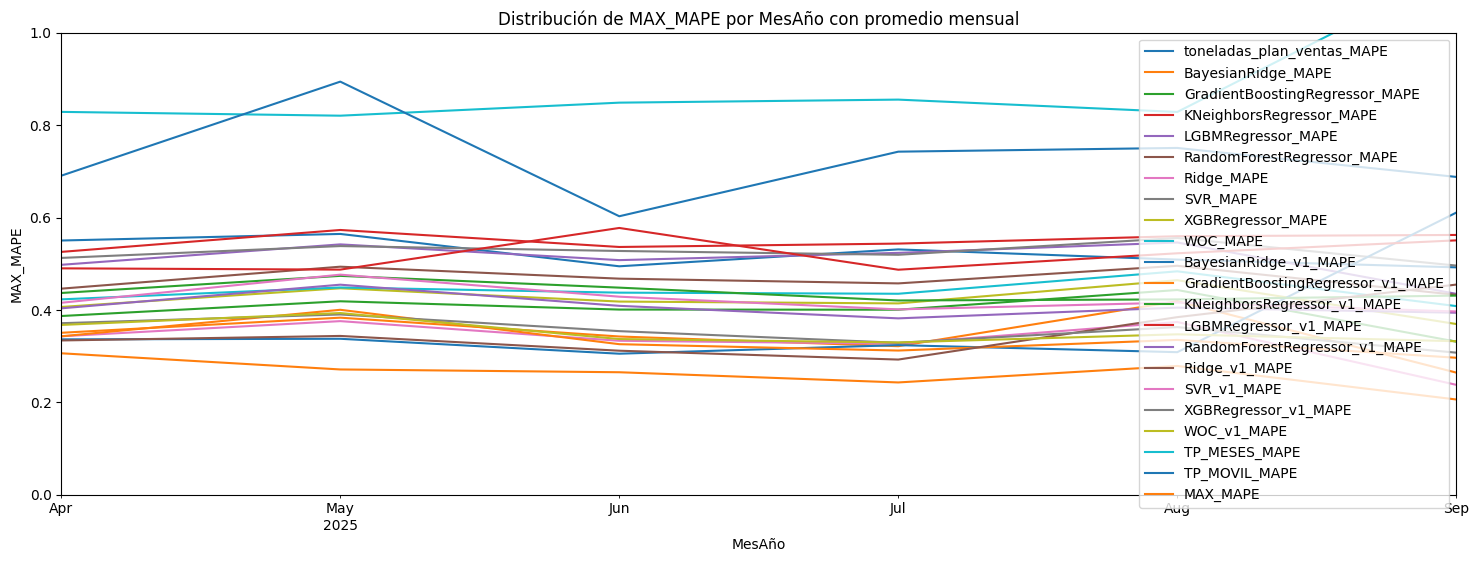

In [17]:

mapes = df.set_index("MesAnio")
mapes = mapes.loc[(mapes.MAX_MODEL == True), mapes.columns[mapes.columns.str.endswith("_MAPE")]].reset_index()
mapes = mapes.drop(columns = "Min_MAPE")

import matplotlib.pyplot as plt
# Crear el gráfico
plt.figure(figsize=(12, 6))
# Lineplot sobre el mismo eje
mapes[mapes.MesAnio < date_today].groupby("MesAnio").mean().plot(figsize=(18, 6))
# Limitar el eje Y de 0 a 1
plt.ylim(0, 1)

# Añadir leyenda y título
plt.legend()
plt.title("Distribución de MAX_MAPE por MesAño con promedio mensual")
plt.xlabel("MesAño")
plt.ylabel("MAX_MAPE")

plt.show()

In [18]:
# prueba de que existen MAPES repetidos......
df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0).sum(axis = 1).value_counts().div(12)

21    1073.0
1      697.0
20     213.0
19      82.0
9       45.0
10      43.0
18      39.0
11      24.0
16      15.0
12      14.0
13      12.0
2       12.0
17       8.0
14       8.0
15       3.0
8        2.0
4        1.0
5        1.0
Name: count, dtype: float64

In [19]:
df[df.MAX_MODEL == True].groupby("id2").MAX_Modelo.first().value_counts()

MAX_Modelo
toneladas_plan_ventas           202
BayesianRidge                   113
Ridge                            95
BayesianRidge_v1                 81
GradientBoostingRegressor        67
Ridge_v1                         47
XGBRegressor                     43
GradientBoostingRegressor_v1     39
KNeighborsRegressor              24
LGBMRegressor                    20
RandomForestRegressor            20
XGBRegressor_v1                  18
WOC                              16
KNeighborsRegressor_v1           13
SVR                              11
SVR_v1                            8
TP_MESES                          7
LGBMRegressor_v1                  7
WOC_v1                            6
TP_MOVIL                          5
RandomForestRegressor_v1          2
Name: count, dtype: int64

In [20]:
df.groupby("id2").MAX_Modelo.first().value_counts()

MAX_Modelo
toneladas_plan_ventas           1491
BayesianRidge                    177
Ridge                             95
BayesianRidge_v1                  81
TP_MOVIL                          73
GradientBoostingRegressor         67
Ridge_v1                          47
XGBRegressor                      43
GradientBoostingRegressor_v1      39
TP_MESES                          34
KNeighborsRegressor               24
RandomForestRegressor             20
LGBMRegressor                     20
XGBRegressor_v1                   18
WOC                               16
KNeighborsRegressor_v1            13
SVR                               11
SVR_v1                             8
LGBMRegressor_v1                   7
WOC_v1                             6
RandomForestRegressor_v1           2
Name: count, dtype: int64

In [21]:
# GUARDAMOS RESULTADOS
from datetime import date
df.to_excel("outputs\Mejor_Pronostico{0}.xlsx".format(date.today(), index = False))

In [22]:
sns.lineplot(mean_mape, x="MesAnio", y="MAX_MAPE")

NameError: name 'sns' is not defined

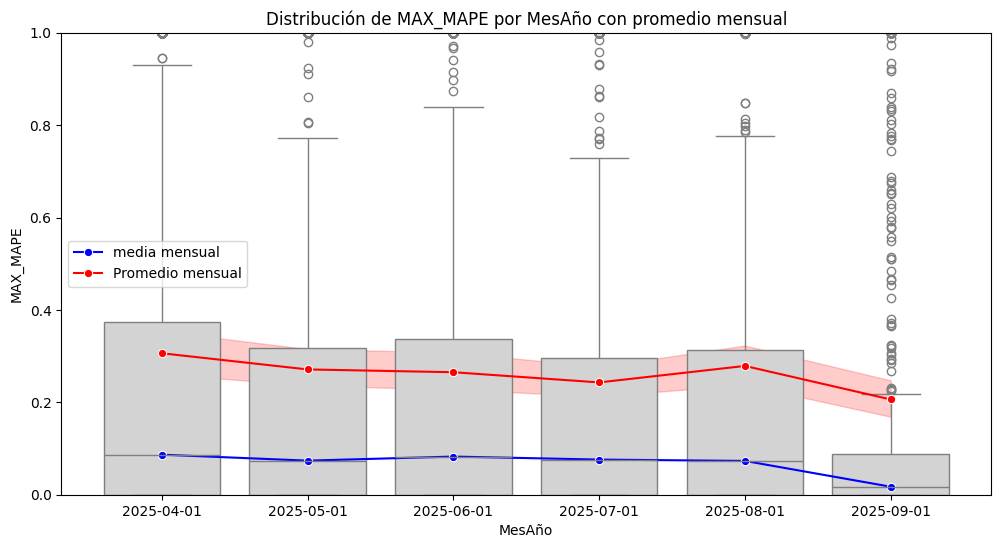

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar el DataFrame según la condición
filtered_df = df[(df.MAX_MODEL == True) & (df.MesAnio < date_today)]

# Calcular el promedio mensual sin convertir a datetime
mean_mape = filtered_df.groupby("MesAnio")['MAX_MAPE'].median().reset_index()
mean_mape['MesAnio'] = mean_mape['MesAnio'].astype(str)
filtered_df['MesAnio'] = filtered_df['MesAnio'].astype(str)

# Crear el gráfico
plt.figure(figsize=(12, 6))
# Lineplot sobre el mismo eje

# Boxplot
sns.boxplot(data=filtered_df, x="MesAnio", y="MAX_MAPE", color="lightgray")
sns.lineplot(data=mean_mape, x="MesAnio", y="MAX_MAPE", marker="o", label="media mensual", color="blue")

sns.lineplot(data=filtered_df, x="MesAnio", y="MAX_MAPE", marker="o", label="Promedio mensual", color="red")

# Limitar el eje Y de 0 a 1
plt.ylim(0, 1)

# Añadir leyenda y título
plt.legend()
plt.title("Distribución de MAX_MAPE por MesAño con promedio mensual")
plt.xlabel("MesAño")
plt.ylabel("MAX_MAPE")

plt.show()


In [24]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]
valores = [df[col]  for col in cols2mape]
# Valores a imputar según condiciones
df['FCST'] = np.select(condiciones, valores, default=None)
df["TO_PLOT"] = np.where(df.Segmento == 'Validacion',df["toneladas_facturadas"], df["FCST"])

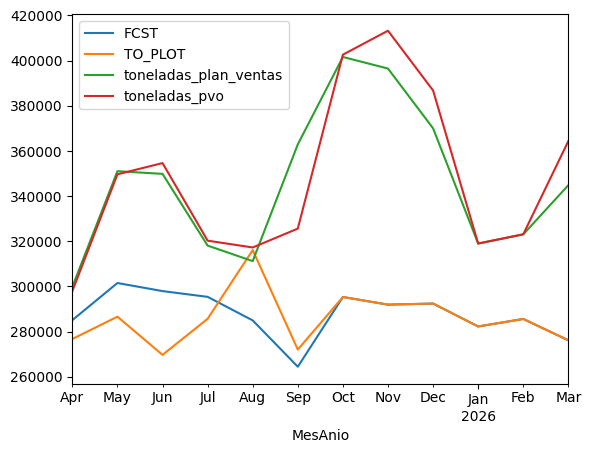

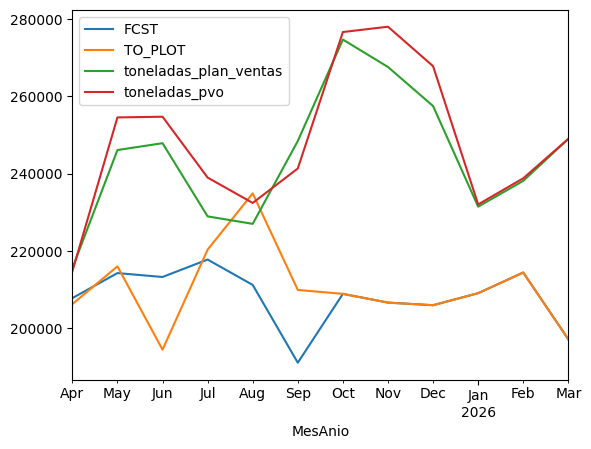

In [25]:
import matplotlib.pyplot as plt
df[  (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"}).plot()
plt.show()
df[ (df.MAX_MODEL== True) & (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"}).plot()
plt.show()

In [26]:
df[ (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"})

,FCST,TO_PLOT,toneladas_plan_ventas,toneladas_pvo
MesAnio,,,,
2025-04-01,285092.076516,276743.213118,299817.871770,297967.42046
2025-05-01,301524.941287,286633.726366,351031.823050,349645.48651
2025-06-01,297946.205631,269710.692785,349852.504730,354624.92090
2025-07-01,295397.357646,285686.192685,318095.420100,320277.35154
2025-08-01,284966.959616,316100.457494,311227.383510,317260.29013
2025-09-01,264464.26574,272063.716466,362910.375110,325611.79792
2025-10-01,295331.020175,295331.020175,401604.164530,402618.81028
2025-11-01,291953.618475,291953.618475,396467.786544,413221.77790
2025-12-01,292429.453264,292429.453264,370013.318034,386766.31583


In [104]:
QUERY_PV = """
SELECT
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS MesAnio,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
#nom_subdireccion AS NombreSubdireccion,
#nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
SUM(toneladas_plan_ventas) AS toneladas_plan_ventas,
SUM(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE EXTRACT(YEAR FROM fecha) >= 2025 # Este es el que vamos a usar en productivo
AND 
nom_grupo IN ('ACEROS', 'ALAMBRES', 'FILIALES ALAMBRES', 'USA','DEACERO SOLUTIONS')
GROUP BY 1,2,3,4,5
"""

PV = data_bq(QUERY_PV)
PV.toneladas_plan_ventas = PV.toneladas_plan_ventas.astype(float)
PV.toneladas_facturadas = PV.toneladas_facturadas.astype(float)
PV.MesAnio = pd.to_datetime(PV.MesAnio)


In [105]:
ax = PV.groupby("MesAnio").agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0)
#ax.set_ylim(210000, 280000)
#plt.show()
ax

,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,
2025-01-01,230504.0,242982.0
2025-02-01,236418.0,217641.0
2025-03-01,246674.0,241413.0
2025-04-01,226953.0,216518.0
2025-05-01,267330.0,224794.0
2025-06-01,267159.0,213490.0
2025-07-01,240284.0,231663.0
2025-08-01,237440.0,247439.0
2025-09-01,258255.0,140955.0


In [113]:
QUERY_HISTORICO_FACTURACION = f"""
with data_base AS (

SELECT

FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS MesAnio,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
toneladas_facturadas AS toneladas_facturadas,
toneladas_plan_ventas AS toneladas_plan_ventas
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE EXTRACT(YEAR FROM fecha) >= {2025} # Este es el que vamos a usar en productivo
AND nom_gerencia NOT IN ('ACERIAS SPOT')

)

# Agregar un cambio de valores para los cuales toneladas_facturadas es 0 si el valor original es negativo

SELECT 
MesAnio,NombreGrupo,NombreDireccion,
NombreSubdireccion,
NombreGrupoEstadistico1,
NombreGrupoEstadistico2,
NombreGrupoEstadistico3,
toneladas_plan_ventas,
CASE 
  #WHEN toneladas_facturadas IS NULL THEN -1
  #WHEN toneladas_facturadas < 0 THEN 0
  WHEN toneladas_facturadas >= 0 THEN toneladas_facturadas
  WHEN toneladas_facturadas < 0 THEN toneladas_facturadas
END toneladas_facturadas
FROM
(
SELECT 
data_base.MesAnio,
data_base.NombreGrupo,
data_base.NombreDireccion,
data_base.NombreSubdireccion,
data_base.NombreGrupoEstadistico1,
data_base.NombreGrupoEstadistico2,
data_base.NombreGrupoEstadistico3,
SUM(data_base.toneladas_facturadas) AS toneladas_facturadas,
SUM(data_base.toneladas_plan_ventas) AS toneladas_plan_ventas
FROM data_base
WHERE 
-- Descartamos los siguientes campos
NombreGrupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND
NombreDireccion NOT IN ('EXPORTACIÓN ALAMBRES')
AND
NombreSubdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
AND
NombreGrupoEstadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS')
AND
NombreGrupoEstadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
AND
NombreGrupoEstadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND MesAnio IS NOT NULL
AND NombreGrupo IS NOT NULL
AND NombreDireccion IS NOT NULL
AND NombreSubdireccion IS NOT NULL
AND NombreGrupoEstadistico1 IS NOT NULL
AND NombreGrupoEstadistico2 IS NOT NULL
AND NombreGrupoEstadistico3 IS NOT NULL
GROUP BY
data_base.MesAnio,
data_base.NombreGrupo,
data_base.NombreDireccion,
data_base.NombreSubdireccion,
data_base.NombreGrupoEstadistico1,
data_base.NombreGrupoEstadistico2,
data_base.NombreGrupoEstadistico3
)
WHERE MesAnio < '2026-02-01'   
ORDER BY MesAnio ASC, toneladas_facturadas DESC
"""

PV = data_bq(QUERY_HISTORICO_FACTURACION)
PV.toneladas_plan_ventas = PV.toneladas_plan_ventas.astype(float)
PV.toneladas_facturadas = PV.toneladas_facturadas.astype(float)
PV.MesAnio = pd.to_datetime(PV.MesAnio)

In [114]:
ax2 = PV.groupby("MesAnio").agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0)
#ax.set_ylim(210000, 280000)
#plt.show()
ax2

,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,
2025-01-01,226840.0,238377.0
2025-02-01,232928.0,211521.0
2025-03-01,233207.0,225184.0
2025-04-01,223044.0,210760.0
2025-05-01,253691.0,217325.0
2025-06-01,254928.0,198934.0
2025-07-01,235226.0,221493.0
2025-08-01,228433.0,233837.0
2025-09-01,249804.0,133604.0


In [117]:
ax3 = FACT[FACT.NombreGrupo.isin(('ACEROS', 'ALAMBRES', 'FILIALES ALAMBRES', 'USA','DEACERO SOLUTIONS'))].groupby("MesAnio").agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0)
ax3

,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,
2025-01-01,230504.0,241909.0
2025-02-01,236418.0,215363.0
2025-03-01,246674.0,239033.0
2025-04-01,226953.0,215068.0
2025-05-01,267330.0,222701.0
2025-06-01,267159.0,211978.0
2025-07-01,240283.0,230111.0
2025-08-01,237440.0,245814.0
2025-09-01,258255.0,139154.0


In [118]:
to_test = ax.merge(ax2, how = "left", left_index = True,  right_index = True, suffixes=("_sin_filtros", "_confiltros"))
to_test = to_test.merge(ax3, how = "left", left_index = True,  right_index = True, suffixes=("", "_pronosticado"))
to_test["delta_pv"] = to_test["toneladas_plan_ventas_sin_filtros"] - to_test["toneladas_plan_ventas_confiltros"]
to_test.round(0)

,toneladas_plan_ventas_sin_filtros,toneladas_facturadas_sin_filtros,toneladas_plan_ventas_confiltros,toneladas_facturadas_confiltros,toneladas_plan_ventas,toneladas_facturadas,delta_pv
MesAnio,,,,,,,
2025-01-01,230504.0,242982.0,226840.0,238377.0,230504.0,241909.0,3664.0
2025-02-01,236418.0,217641.0,232928.0,211521.0,236418.0,215363.0,3490.0
2025-03-01,246674.0,241413.0,233207.0,225184.0,246674.0,239033.0,13467.0
2025-04-01,226953.0,216518.0,223044.0,210760.0,226953.0,215068.0,3909.0
2025-05-01,267330.0,224794.0,253691.0,217325.0,267330.0,222701.0,13639.0
2025-06-01,267159.0,213490.0,254928.0,198934.0,267159.0,211978.0,12231.0
2025-07-01,240284.0,231663.0,235226.0,221493.0,240283.0,230111.0,5058.0
2025-08-01,237440.0,247439.0,228433.0,233837.0,237440.0,245814.0,9007.0
2025-09-01,258255.0,140955.0,249804.0,133604.0,258255.0,139154.0,8451.0


In [70]:
ax = PV.groupby("MesAnio").agg({"toneladas_plan_ventas" : "sum" , "Toneladas_Facturadas": "sum"}).round(0)
#ax.set_ylim(210000, 280000)
#plt.show()
ax

,toneladas_plan_ventas,Toneladas_Facturadas
MesAnio,,
2025-01-01,226840.0,238520.788738000
2025-02-01,232928.0,211901.494838600
2025-03-01,233207.0,225601.163323300
2025-04-01,223044.0,211201.058465000
2025-05-01,253691.0,217533.690642100
2025-06-01,254928.0,198968.627792864
2025-07-01,235226.0,221497.078757624
2025-08-01,228433.0,233883.815011986
2025-09-01,249804.0,133605.737061966


In [58]:
FACT[FACT.NombreGrupo != "TRASPASOS E INTEREMPRESAS"].groupby(["NombreGrupo", "MesAnio"]).agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0).unstack(0)

FACT[FACT.NombreGrupo != "TRASPASOS E INTEREMPRESAS"].groupby([ "MesAnio"]).agg({"toneladas_plan_ventas" : "sum" , "toneladas_facturadas": "sum"}).round(0)

,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,
2025-01-01,230504.0,241909.0
2025-02-01,236418.0,215363.0
2025-03-01,246674.0,239033.0
2025-04-01,226953.0,215068.0
2025-05-01,267330.0,222701.0
2025-06-01,267159.0,211978.0
2025-07-01,240283.0,230111.0
2025-08-01,237440.0,245814.0
2025-09-01,258255.0,139154.0
